In [180]:
import numpy as np

data = np.load('wafer_dataset/Wafer_Map_Datasets.npz')
print(data.files)

['arr_0', 'arr_1']


In [181]:
data['arr_0'].shape, data['arr_1'].shape

((38015, 52, 52), (38015, 8))

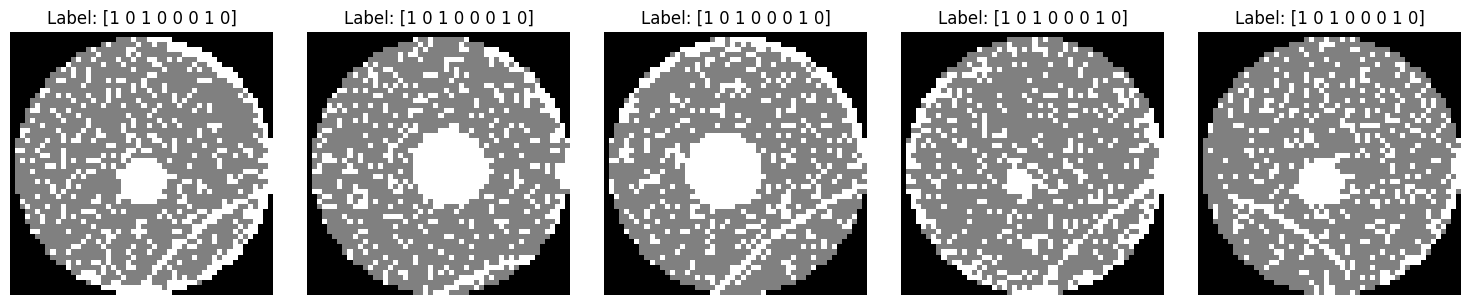

In [182]:
import matplotlib.pyplot as plt

# 取前五張圖片與對應的 label
images = data['arr_0'][:5]
labels = data['arr_1'][:5]

# 畫圖
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [183]:
from sklearn.model_selection import train_test_split

wafer = data['arr_0']
label = data['arr_1']
X_train, X_test, y_train, y_test = train_test_split(wafer, label, test_size = 0.2)

In [185]:
# from torch.utils.data import Dataset
# import json

# class My_Dataset(Dataset):
    
#     def __init__(self, X, y, transform = None):
# #         self.data_path = data_path
# #         self.data = np.load(data_path)
#         self.images = X.reshape(-1,1, 52, 52)
#         self.one_hot_labels = y
#         self.transform = transform
        
#         self.classes_dict = {
#             "00000000":0,
#             "10000000":1,
#             "01000000":2,
#             "00100000":3,
#             "00010000":4,
#             "00001000":5,
#             "00000100":6,
#             "00000010":7,
#             "00000001":8,
#             "10100000":9,
#             "10010000":10,
#             "10001000":11,
#             "10000010":12,
#             "01100000":13,
#             "01010000":14,
#             "01001000":15,
#             "01000010":16,
#             "00101000":17,
#             "00100010":18,
#             "00011000":19,
#             "00010010":20,
#             "00001010":21,
#             "10101000":22,
#             "10100010":23,
#             "10011000":24,
#             "10010010":25,
#             "10001010":26,
#             "01101000":27,
#             "01100010":28,
#             "01011000":29,
#             "01010010":30,
#             "01001010":31,
#             "00101010":32,
#             "00011010":33,
#             "10101010":34,
#             "10011010":35,
#             "01101010":36,
#             "01011010":37,
#         }
        
        
#         self.classes_num_dict = {}
        
#         json_str = json.dumps(self.classes_dict, indent = 4)
#         with open( "classes_dict.json" , 'w') as json_file:
#             json_file.write(json_str)
        
        
#         self.image_labels = []
#         self.images_num = []
        
#         cnt = 0
#         for one_hot_label in self.one_hot_labels:
#             cnt += 1
#             t = ""
#             for ch in one_hot_label:
#                 if ch == None:
#                     t += str(0)
#                 else:
#                     t += str(ch)
#             label = self.classes_dict[t]
#             if label  not in self.classes_num_dict:
#                 self.classes_num_dict[label] = 1
#             else:
#                 self.classes_num_dict[label] += 1
#             self.image_labels.append(label)
            
#         for i in sorted(list(self.classes_num_dict.keys())):
#             self.images_num.append(self.classes_num_dict[i])
        
#         self.num_classes = len(self.classes_num_dict)
        
#         print("num_class：", self.num_classes)
#         print("{}/{} images were  found in the dataset.".format(cnt, sum(self.images_num)))
            
        
#     def __len__(self):
#         return sum(self.images_num)
    
#     def __getitem__(self, idx):
#         image = self.images[idx]
#         label = self.image_labels[idx]
#         if self.transform is not None:
#             image = self.transform(image)
#         return image, label

In [186]:
from torch.utils.data import Dataset
import json
import numpy as np

class My_Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.images = X.reshape(-1, 1, 52, 52)
        self.one_hot_labels = y
        self.transform = transform

        # 只保留 0~8 類別
        self.classes_dict = {
            "00000000": 0,
            "10000000": 1,
            "01000000": 2,
            "00100000": 3,
            "00010000": 4,
            "00001000": 5,
            "00000100": 6,
            "00000010": 7,
            "00000001": 8
        }

        # 反向查找表（可選）
        json_str = json.dumps(self.classes_dict, indent=4)
        with open("classes_dict.json", 'w') as json_file:
            json_file.write(json_str)

        self.image_labels = []
        self.filtered_images = []

        self.classes_num_dict = {}

        for i, one_hot_label in enumerate(self.one_hot_labels):
            t = ''.join(str(int(ch)) if ch is not None else '0' for ch in one_hot_label)
            if t in self.classes_dict:
                label = self.classes_dict[t]
                self.filtered_images.append(self.images[i])
                self.image_labels.append(label)
                if label not in self.classes_num_dict:
                    self.classes_num_dict[label] = 1
                else:
                    self.classes_num_dict[label] += 1

        self.images = np.array(self.filtered_images)
        self.num_classes = len(self.classes_num_dict)
        self.images_num = [self.classes_num_dict[i] for i in sorted(self.classes_num_dict.keys())]

        print("num_class:", self.num_classes)
        print("{}/{} images retained in 0–8 classes.".format(len(self.images), len(X)))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.image_labels[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label


In [187]:
train_dataset = My_Dataset(X_train, y_train)
test_dataset = My_Dataset(X_test, y_test)

num_class: 9
6420/30412 images retained in 0–8 classes.
num_class: 9
1595/7603 images retained in 0–8 classes.


In [188]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch

def save_dataset_to_folder(dataset, split_name="train", root_dir="wafer_dataset"):
    output_dir = Path(root_dir) / split_name
    os.makedirs(output_dir, exist_ok=True)

    for idx in tqdm(range(len(dataset)), desc=f"Saving {split_name} set"):
        img, label = dataset[idx]
        label_dir = output_dir / str(label)
        label_dir.mkdir(parents=True, exist_ok=True)

        # 處理 Tensor -> numpy 並壓縮維度
        img_np = img.squeeze()
        if isinstance(img_np, torch.Tensor):
            img_np = img_np.numpy()

        # ⭐ 將圖像值從 0,1,2 轉換為對應灰階強度，增加可視化效果：
        #   0 → 0 (黑), 1 → 127 (灰), 2 → 255 (白)
        img_gray = (img_np * 127).astype(np.uint8)

        img_path = label_dir / f"img_{idx}.png"
        cv2.imwrite(str(img_path), img_gray)


# 匯出 train 與 test 資料集
save_dataset_to_folder(train_dataset, split_name="train", root_dir="wafer_dataset")
save_dataset_to_folder(test_dataset, split_name="val", root_dir="wafer_dataset")

Saving val set: 100%|██████████| 1595/1595 [00:00<00:00, 25813.84it/s]


In [ ]:
# import matplotlib.pyplot as plt

# img, label = train_dataset[0]
# img_np = img.squeeze()

# plt.imshow(img_np, cmap='gray')
# plt.title(f"Label: {label}")
# plt.colorbar()
# plt.show()

# print("像素值統計：", np.unique(img_np, return_counts=True))


In [190]:
from ultralytics import YOLO
model = YOLO('yolov8s-cls.pt')
model.model.model[-1].linear.out_features = 9
model

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [191]:
model.train(
    data='wafer_dataset',  # 資料夾包含 train/ val/
    imgsz=52,
    epochs=100,
    batch=256,
    name='yolov8-wafer-cls',
    device='cuda'
)

Ultralytics 8.3.99 🚀 Python-3.12.0 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24118MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=wafer_dataset, epochs=100, time=None, patience=100, batch=256, imgsz=52, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolov8-wafer-cls5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /home/ntu-weal222c/ianpeng/pmba_yolo/wafer_dataset/train... 6420 images, 0 corrupt: 100%|██████████| 6420/6420 [00:00<00:00, 27450.81it/s]

train: New cache created: /home/ntu-weal222c/ianpeng/pmba_yolo/wafer_dataset/train.cache



val: Scanning /home/ntu-weal222c/ianpeng/pmba_yolo/wafer_dataset/val... 1595 images, 0 corrupt: 100%|██████████| 1595/1595 [00:00<00:00, 20544.84it/s]

val: New cache created: /home/ntu-weal222c/ianpeng/pmba_yolo/wafer_dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.002), 27 bias(decay=0.0)
Image sizes 64 train, 64 val
Using 8 dataloader workers
Logging results to runs/classify/yolov8-wafer-cls5
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      0.93G      2.114         20         64: 100%|██████████| 26/26 [00:00<00:00, 43.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 110.46it/s]

                   all      0.505      0.826



      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.04G       1.21         20         64: 100%|██████████| 26/26 [00:00<00:00, 69.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.68it/s]

                   all      0.754      0.996



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.04G     0.5823         20         64: 100%|██████████| 26/26 [00:00<00:00, 89.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.15it/s]

                   all      0.913      0.999



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.04G     0.3768         20         64: 100%|██████████| 26/26 [00:00<00:00, 92.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.58it/s]

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      1.04G     0.3472         20         64: 100%|██████████| 26/26 [00:00<00:00, 85.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.83it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.04G     0.2957         20         64: 100%|██████████| 26/26 [00:00<00:00, 76.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 171.04it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.04G     0.2803         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.10it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.04G     0.2593         20         64: 100%|██████████| 26/26 [00:00<00:00, 68.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 140.65it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      1.04G     0.2286         20         64: 100%|██████████| 26/26 [00:00<00:00, 72.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 175.97it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.04G     0.2493         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 159.03it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.04G     0.2406         20         64: 100%|██████████| 26/26 [00:00<00:00, 76.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 122.14it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.04G     0.2145         20         64: 100%|██████████| 26/26 [00:00<00:00, 71.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.05it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.04G     0.2158         20         64: 100%|██████████| 26/26 [00:00<00:00, 70.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.76it/s]


                   all      0.987          1

      Epoch    GPU_mem       loss  Instances       Size


     14/100      1.04G     0.2242         20         64: 100%|██████████| 26/26 [00:00<00:00, 78.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 177.07it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      1.04G     0.2225         20         64: 100%|██████████| 26/26 [00:00<00:00, 77.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 135.22it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      1.04G     0.2184         20         64: 100%|██████████| 26/26 [00:00<00:00, 76.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 175.67it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      1.04G      0.231         20         64: 100%|██████████| 26/26 [00:00<00:00, 71.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.91it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      1.04G     0.2189         20         64: 100%|██████████| 26/26 [00:00<00:00, 78.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 172.79it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100      1.04G     0.2121         20         64: 100%|██████████| 26/26 [00:00<00:00, 70.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.02it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      1.04G      0.197         20         64: 100%|██████████| 26/26 [00:00<00:00, 72.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.32it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100      1.04G     0.1927         20         64: 100%|██████████| 26/26 [00:00<00:00, 85.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 177.01it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      1.04G     0.1984         20         64: 100%|██████████| 26/26 [00:00<00:00, 79.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.08it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      1.04G     0.1909         20         64: 100%|██████████| 26/26 [00:00<00:00, 81.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 172.47it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100      1.04G      0.208         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 137.96it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      1.04G     0.2043         20         64: 100%|██████████| 26/26 [00:00<00:00, 74.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 146.15it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      1.04G     0.1865         20         64: 100%|██████████| 26/26 [00:00<00:00, 74.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.38it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100      1.04G     0.1727         20         64: 100%|██████████| 26/26 [00:00<00:00, 72.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.46it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      1.04G     0.1712         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 171.22it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      1.04G     0.1658         20         64: 100%|██████████| 26/26 [00:00<00:00, 72.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.63it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      1.04G     0.1653         20         64: 100%|██████████| 26/26 [00:00<00:00, 79.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 175.18it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      1.04G     0.1773         20         64: 100%|██████████| 26/26 [00:00<00:00, 68.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.52it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      1.04G     0.1929         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 177.43it/s]

                   all      0.985      0.999



      Epoch    GPU_mem       loss  Instances       Size


     33/100      1.04G     0.2198         20         64: 100%|██████████| 26/26 [00:00<00:00, 65.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 138.95it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      1.04G     0.1971         20         64: 100%|██████████| 26/26 [00:00<00:00, 74.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.42it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100      1.04G     0.1685         20         64: 100%|██████████| 26/26 [00:00<00:00, 88.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 165.64it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      1.04G     0.1886         20         64: 100%|██████████| 26/26 [00:00<00:00, 71.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 141.80it/s]


                   all      0.987          1

      Epoch    GPU_mem       loss  Instances       Size


     37/100      1.04G     0.1774         20         64: 100%|██████████| 26/26 [00:00<00:00, 80.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 170.93it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      1.04G     0.1714         20         64: 100%|██████████| 26/26 [00:00<00:00, 68.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.71it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100      1.04G     0.1568         20         64: 100%|██████████| 26/26 [00:00<00:00, 79.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 171.65it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100      1.04G     0.1645         20         64: 100%|██████████| 26/26 [00:00<00:00, 90.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.71it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100      1.04G     0.1631         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 150.05it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100      1.04G     0.1587         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 175.01it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100      1.04G     0.1611         20         64: 100%|██████████| 26/26 [00:00<00:00, 77.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.65it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100      1.04G     0.1601         20         64: 100%|██████████| 26/26 [00:00<00:00, 72.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.63it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100      1.04G     0.1616         20         64: 100%|██████████| 26/26 [00:00<00:00, 80.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 175.71it/s]


                   all      0.992          1

      Epoch    GPU_mem       loss  Instances       Size


     46/100      1.04G     0.1683         20         64: 100%|██████████| 26/26 [00:00<00:00, 72.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.07it/s]


                   all      0.991          1

      Epoch    GPU_mem       loss  Instances       Size


     47/100      1.04G     0.1552         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 172.32it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100      1.04G      0.151         20         64: 100%|██████████| 26/26 [00:00<00:00, 81.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 160.31it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100      1.04G     0.1593         20         64: 100%|██████████| 26/26 [00:00<00:00, 71.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.99it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100      1.04G     0.1541         20         64: 100%|██████████| 26/26 [00:00<00:00, 77.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 170.27it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100      1.04G     0.1585         20         64: 100%|██████████| 26/26 [00:00<00:00, 76.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 149.02it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100      1.04G     0.1478         20         64: 100%|██████████| 26/26 [00:00<00:00, 72.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 175.58it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100      1.04G     0.1275         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 172.20it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100      1.04G     0.1506         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 169.72it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100      1.04G     0.1471         20         64: 100%|██████████| 26/26 [00:00<00:00, 76.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 138.43it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100      1.04G     0.1461         20         64: 100%|██████████| 26/26 [00:00<00:00, 69.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 149.54it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100      1.04G     0.1395         20         64: 100%|██████████| 26/26 [00:00<00:00, 68.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 171.76it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100      1.04G     0.1491         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.75it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100      1.04G     0.1373         20         64: 100%|██████████| 26/26 [00:00<00:00, 72.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 175.61it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100      1.04G     0.1436         20         64: 100%|██████████| 26/26 [00:00<00:00, 75.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.69it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100      1.04G     0.1437         20         64: 100%|██████████| 26/26 [00:00<00:00, 76.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 175.36it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     62/100      1.04G     0.1366         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 175.59it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100      1.04G     0.1413         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 144.96it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100      1.04G     0.1285         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.19it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100      1.04G     0.1263         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.47it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     66/100      1.04G      0.135         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.91it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     67/100      1.04G     0.1389         20         64: 100%|██████████| 26/26 [00:00<00:00, 78.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 170.85it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     68/100      1.04G     0.1286         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.64it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     69/100      1.04G     0.1496         20         64: 100%|██████████| 26/26 [00:00<00:00, 71.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.74it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100      1.04G     0.1365         20         64: 100%|██████████| 26/26 [00:00<00:00, 77.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 177.17it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     71/100      1.04G     0.1448         20         64: 100%|██████████| 26/26 [00:00<00:00, 66.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.15it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     72/100      1.04G     0.1387         20         64: 100%|██████████| 26/26 [00:00<00:00, 71.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 177.39it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100      1.04G     0.1485         20         64: 100%|██████████| 26/26 [00:00<00:00, 71.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 165.12it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100      1.04G     0.1397         20         64: 100%|██████████| 26/26 [00:00<00:00, 67.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.01it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100      1.04G     0.1349         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 148.88it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100      1.04G     0.1471         20         64: 100%|██████████| 26/26 [00:00<00:00, 70.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 141.24it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     77/100      1.04G     0.1394         20         64: 100%|██████████| 26/26 [00:00<00:00, 74.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.58it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     78/100      1.04G     0.1381         20         64: 100%|██████████| 26/26 [00:00<00:00, 82.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 170.53it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     79/100      1.04G     0.1367         20         64: 100%|██████████| 26/26 [00:00<00:00, 82.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 171.92it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     80/100      1.04G     0.1272         20         64: 100%|██████████| 26/26 [00:00<00:00, 85.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 172.46it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     81/100      1.04G     0.1391         20         64: 100%|██████████| 26/26 [00:00<00:00, 68.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 172.78it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     82/100      1.04G     0.1271         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.64it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     83/100      1.04G     0.1393         20         64: 100%|██████████| 26/26 [00:00<00:00, 76.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.38it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     84/100      1.04G      0.127         20         64: 100%|██████████| 26/26 [00:00<00:00, 71.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 150.65it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     85/100      1.04G     0.1165         20         64: 100%|██████████| 26/26 [00:00<00:00, 74.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.04it/s]


                   all      0.994          1

      Epoch    GPU_mem       loss  Instances       Size


     86/100      1.04G     0.1243         20         64: 100%|██████████| 26/26 [00:00<00:00, 77.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 139.87it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     87/100      1.04G     0.1199         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 138.15it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     88/100      1.04G     0.1278         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 138.08it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     89/100      1.04G     0.1279         20         64: 100%|██████████| 26/26 [00:00<00:00, 66.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.60it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     90/100      1.04G     0.1225         20         64: 100%|██████████| 26/26 [00:00<00:00, 77.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.79it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     91/100      1.04G     0.1157         20         64: 100%|██████████| 26/26 [00:00<00:00, 46.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.25it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     92/100      1.04G      0.126         20         64: 100%|██████████| 26/26 [00:00<00:00, 78.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 142.11it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     93/100      1.04G      0.123         20         64: 100%|██████████| 26/26 [00:00<00:00, 71.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 161.74it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     94/100      1.04G     0.1199         20         64: 100%|██████████| 26/26 [00:00<00:00, 65.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 136.69it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     95/100      1.04G     0.1214         20         64: 100%|██████████| 26/26 [00:00<00:00, 76.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 176.04it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     96/100      1.04G     0.1209         20         64: 100%|██████████| 26/26 [00:00<00:00, 81.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 173.85it/s]


                   all      0.994          1

      Epoch    GPU_mem       loss  Instances       Size


     97/100      1.04G     0.1239         20         64: 100%|██████████| 26/26 [00:00<00:00, 81.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 172.61it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     98/100      1.04G     0.1179         20         64: 100%|██████████| 26/26 [00:00<00:00, 72.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 149.33it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     99/100      1.04G     0.1261         20         64: 100%|██████████| 26/26 [00:00<00:00, 76.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 133.87it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


    100/100      1.04G     0.1341         20         64: 100%|██████████| 26/26 [00:00<00:00, 73.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 174.44it/s]

                   all      0.994          1



100 epochs completed in 0.013 hours.
Optimizer stripped from runs/classify/yolov8-wafer-cls5/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/yolov8-wafer-cls5/weights/best.pt, 10.3MB

Validating runs/classify/yolov8-wafer-cls5/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.12.0 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24118MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,086,729 parameters, 0 gradients, 12.5 GFLOPs
train: /home/ntu-weal222c/ianpeng/pmba_yolo/wafer_dataset/train... found 6420 images in 9 classes ✅ 
val: /home/ntu-weal222c/ianpeng/pmba_yolo/wafer_dataset/val... found 1595 images in 9 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 131.27it/s]


                   all      0.996          1
Speed: 0.0ms preprocess, 0.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolov8-wafer-cls5


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x702b77a50530>
curves: []
curves_results: []
fitness: 0.997805655002594
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.995611310005188, 'metrics/accuracy_top5': 1.0, 'fitness': 0.997805655002594}
save_dir: PosixPath('runs/classify/yolov8-wafer-cls5')
speed: {'preprocess': 0.007845708358810986, 'inference': 0.006270788166216548, 'loss': 9.016019984098813e-06, 'postprocess': 1.1877136357525674e-05}
task: 'classify'
top1: 0.995611310005188
top5: 1.0

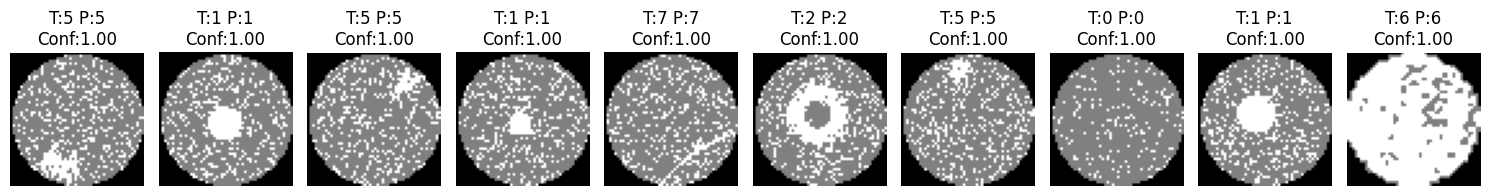

In [195]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 設定 val 資料夾路徑
val_root = 'wafer_dataset/val'

# 載入模型
model = YOLO('runs/classify/yolov8-wafer-cls5/weights/best.pt')

# 取得所有類別資料夾（0 ~ 37）
class_dirs = [d for d in os.listdir(val_root) if os.path.isdir(os.path.join(val_root, d))]

# 隨機選幾張圖片
n_samples = 10
samples = []

while len(samples) < n_samples:
    cls = random.choice(class_dirs)
    cls_path = os.path.join(val_root, cls)
    img_files = os.listdir(cls_path)
    if img_files:
        img_file = random.choice(img_files)
        img_path = os.path.join(cls_path, img_file)
        samples.append((img_path, int(cls)))  # (圖片路徑, 真實類別)

# 可視化
plt.figure(figsize=(15, 3))
for i, (img_path, true_label) in enumerate(samples):
    # 預測（直接用圖片路徑）
    results = model.predict(img_path, device='cuda', verbose=False)
    pred_label = int(results[0].probs.top1)
    conf = float(results[0].probs.top1conf)

    # 顯示圖像（讀成灰階只為了顯示）
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(img_gray, cmap='gray')
    plt.title(f"T:{true_label} P:{pred_label}\nConf:{conf:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()
